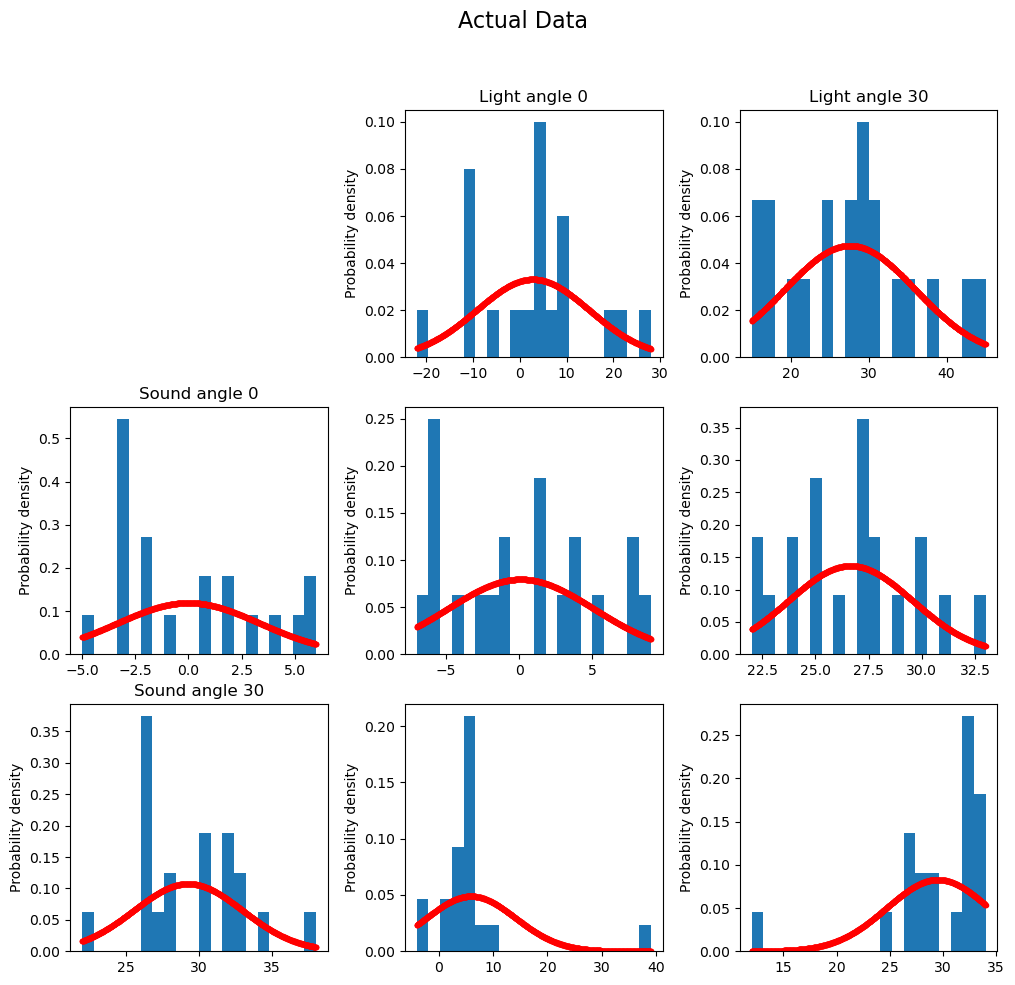

In [17]:
###-------------------------------------------------------------------------------------------------------------------
#         visualizing data and theoretical normal distribution curve
###-------------------------------------------------------------------------------------------------------------------
import csv
import numpy as np
from matplotlib.pyplot import (figure, title, subplot, plot, hist, show, ylabel, subplots, delaxes, subplots_adjust, legend, clf)
from scipy import stats

# norm. pdf negative log likelihood -> calculate it's fit and optimize with dynamic weights
# second model just do the same and weight the results of the norm.pdf's with the p(c) and p(c=1) 
# probabilities and take the according tbings of course

tuple_list = ((0,1), (0,2), (1,0), (2,0), (1,1), (1,2), (2,1), (2,2))
with open('Homework3pt1DataCSV.csv') as csvfile:
    csv_reader = csv.reader(csvfile, delimiter=' ')
    
    # Plot the histogram
    fig, axs = subplots(3,3, figsize=(10, 10))
    fig.tight_layout()
    fig.suptitle("Actual Data", fontsize=16)
    fig.subplots_adjust(top=0.88)
    
    for i, row in enumerate(csv_reader):
        row = [item for item in row if item != '']
        row = list(map(float, row)) 
        
        axs[tuple_list[i]].hist(row, bins=len(row), density=True)
        axs[tuple_list[i]].set_ylabel("Probability density")
        # Over the histogram, plot the theoretical probability distribution function:
        x = np.linspace(np.min(row), np.max(row), 1000)
        pdf = stats.norm.pdf(x,loc=np.mean(row),scale=np.std(row))
        axs[tuple_list[i]].plot(x,pdf,'.',color='red')
        
        
    delaxes(axs[0,0])
    subplots_adjust(wspace=0.3, hspace=0.2)
    axs[0,1].set_title("Light angle 0")
    axs[0,2].set_title("Light angle 30")
    axs[1,0].set_title("Sound angle 0")
    axs[2,0].set_title("Sound angle 30")

In [18]:
###-------------------------------------------------------------------------------------------------------------------
#         function - plotting data with resulting model curves - stemming from the optimized parameters
###-------------------------------------------------------------------------------------------------------------------
def plot_curves(sol, name):
    figure
    w_0 = sol.x[5]**2 / (sol.x[4]**2 + sol.x[4]**2)


    mu_combined_sound_visual_0_0 = w_0 * sol.x[0] + (1 - w_0) * sol.x[2]
    sigma_combined_sound_visual_0_0 = w_0**2 * sol.x[4]**2 + (1 - w_0)**2 * sol.x[5]**2

    mu_combined_sound_visual_0_30 = w_0 * sol.x[0] + (1 - w_0) * sol.x[3]
    sigma_combined_sound_visual_0_30 = w_0**2 * sol.x[4]**2 + (1 - w_0)**2 * sol.x[5]**2

    mu_combined_sound_visual_30_0 = w_0 * sol.x[1] + (1 - w_0) * sol.x[2]
    sigma_combined_sound_visual_30_0 = w_0**2 * sol.x[4]**2 + (1 - w_0)**2 * sol.x[5]**2

    mu_combined_sound_visual_30_30 = w_0 * sol.x[1] + (1 - w_0) * sol.x[3]
    sigma_combined_sound_visual_30_30 = w_0**2 * sol.x[4]**2 + (1 - w_0)**2 * sol.x[5]**2


    mu_array = [sol.x[0], sol.x[1], sol.x[2], sol.x[3], 
                mu_combined_sound_visual_0_0, mu_combined_sound_visual_0_30,
                mu_combined_sound_visual_30_0, mu_combined_sound_visual_30_30]
    sigma_array = [sol.x[4], sol.x[4], sol.x[5], sol.x[5],
                  sigma_combined_sound_visual_0_0, sigma_combined_sound_visual_0_30,
                  sigma_combined_sound_visual_30_0, sigma_combined_sound_visual_30_30]


    tuple_list = ((0,1), (0,2), (1,0), (2,0), (1,1), (1,2), (2,1), (2,2))
    with open('Homework3pt1DataCSV.csv') as csvfile:
        csv_reader = csv.reader(csvfile, delimiter=' ')

        # plot the histogram
        fig, axs = subplots(3,3, figsize=(10, 10))
        fig.tight_layout()
        fig.suptitle(name, fontsize=16)
        fig.subplots_adjust(top=0.88)

        for i, row in enumerate(csv_reader):
            row = [item for item in row if item != '']
            row = list(map(float, row)) 

            axs[tuple_list[i]].hist(row, bins=len(row), density=True)
            axs[tuple_list[i]].set_ylabel("Probability density")
            # over the histogram, plot the theoretical probability distribution function:
            x = np.linspace(np.min(row), np.max(row), 1000)
            pdf = stats.norm.pdf(x,loc=mu_array[i],scale=sigma_array[i])
            axs[tuple_list[i]].plot(x,pdf,'.',color='red')

        delaxes(axs[0,0])
        subplots_adjust(wspace=0.3, hspace=0.2)
        axs[0,1].set_title("Light angle 0")
        axs[0,2].set_title("Light angle 30")
        axs[1,0].set_title("Sound angle 0")
        axs[2,0].set_title("Sound angle 30")

In [19]:
###-------------------------------------------------------------------------------------------------------------------
#         functions - to be optimized - MLE and BCI model
###-------------------------------------------------------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
import csv
import numpy as np
from matplotlib.pyplot import (figure, title, subplot, plot, hist, show, ylabel, subplots, delaxes, subplots_adjust, legend, clf)
from scipy import stats
from scipy.stats import norm
import numpy as np
from scipy.optimize import minimize
import math

###-------------------------------------------------------------------------------------------------------------------
#         MLE model
###-------------------------------------------------------------------------------------------------------------------
def optimize_all_parameters(arguments):
    mu_sound_0, mu_sound_30 = arguments[0], arguments[1]
    mu_visual_0, mu_visual_30 = arguments[2], arguments[3]
    sigma_sound, sigma_visual = arguments[4], arguments[5]
    
    sum_log_pdf = 0
            
    # only sound
    sum_log_pdf += sum(norm.logpdf(d.loc[:, "sound_0"], mu_sound_0, sigma_sound))
    sum_log_pdf += sum(norm.logpdf(d.loc[:, "sound_30"], mu_sound_30, sigma_sound))

    # only visual
    sum_log_pdf += sum(norm.logpdf(d.loc[:, "visual_0"], mu_visual_0, sigma_visual))
    sum_log_pdf += sum(norm.logpdf(d.loc[:, "visual_30"], mu_visual_30, sigma_visual))

    
    # combined - 0
    w_0 = sigma_visual**2 / (sigma_sound**2 + sigma_visual**2)
    
    sigma_combined_sound_visual = w_0**2 * sigma_sound**2 + (1 - w_0)**2 * sigma_visual**2

    mu_combined_sound_visual_0_0 = w_0 * mu_sound_0 + (1 - w_0) * mu_visual_0

    mu_combined_sound_visual_0_30 = w_0 * mu_sound_0 + (1 - w_0) * mu_visual_30

    mu_combined_sound_visual_30_0 = w_0 * mu_sound_30 + (1 - w_0) * mu_visual_0

    mu_combined_sound_visual_30_30 = w_0 * mu_sound_30 + (1 - w_0) * mu_visual_30

    sum_log_pdf += sum(norm.logpdf(d.loc[:, "sound_visual_0_0"], mu_combined_sound_visual_0_0, sigma_combined_sound_visual))
    sum_log_pdf += sum(norm.logpdf(d.loc[:, "sound_visual_0_30"], mu_combined_sound_visual_0_30, sigma_combined_sound_visual))
    sum_log_pdf += sum(norm.logpdf(d.loc[:, "sound_visual_30_0"], mu_combined_sound_visual_30_0, sigma_combined_sound_visual))
    sum_log_pdf += sum(norm.logpdf(d.loc[:, "sound_visual_30_30"], mu_combined_sound_visual_30_30, sigma_combined_sound_visual))
    
    return -sum_log_pdf



###-------------------------------------------------------------------------------------------------------------------
#         BCI model
###-------------------------------------------------------------------------------------------------------------------
def optimize_all_parameters_bci(arguments):
    mu_sound_0, mu_sound_30 = arguments[0], arguments[1]
    mu_visual_0, mu_visual_30 = arguments[2], arguments[3]
    sigma_sound, sigma_visual = arguments[4], arguments[5]
    c =  arguments[6]
    
    sum_log_pdf = 0
    
    p_c = 1/(1 + math.exp(-c))
    
    # only sound
    sum_log_pdf += sum(norm.logpdf(d.loc[:, "sound_0"], mu_sound_0, sigma_sound))
    sum_log_pdf += sum(norm.logpdf(d.loc[:, "sound_30"], mu_sound_30, sigma_sound))
        
    # only visual
    sum_log_pdf += sum(norm.logpdf(d.loc[:, "visual_0"], mu_visual_0, sigma_visual))
    sum_log_pdf += sum(norm.logpdf(d.loc[:, "visual_30"], mu_visual_30, sigma_visual))
    
    
    w_0 = sigma_visual ** 2 / (sigma_sound ** 2 + sigma_visual ** 2)
        
    sigma_combined_sound_visual = w_0**2 * sigma_sound**2 + (1 - w_0)**2 * sigma_visual**2

    mu_combined_sound_visual_0_0 = w_0 * mu_sound_0 + (1 - w_0) * mu_visual_0

    mu_combined_sound_visual_0_30 = w_0 * mu_sound_0 + (1 - w_0) * mu_visual_30

    mu_combined_sound_visual_30_0 = w_0 * mu_sound_30 + (1 - w_0) * mu_visual_0

    mu_combined_sound_visual_30_30 = w_0 * mu_sound_30 + (1 - w_0) * mu_visual_30
    
    # CONFUSED (EITHER OUTCOMENTET OR COMMENTED)
    s_v_0_0 = norm.pdf(d.loc[:, "sound_visual_0_0"], mu_combined_sound_visual_0_0, sigma_combined_sound_visual)
    s_0 = norm.pdf(d.loc[:, "sound_visual_0_0"], mu_sound_0, sigma_sound)
    sum_log_pdf += sum(np.log(s_v_0_0 * p_c + s_0 * (1 - p_c)))
        
    s_v_0_30 = norm.pdf(d.loc[:, "sound_visual_0_30"], mu_combined_sound_visual_0_30, sigma_combined_sound_visual)
    s_0 = norm.pdf(d.loc[:, "sound_visual_0_30"], mu_sound_0, sigma_sound)
    sum_log_pdf += sum(np.log(s_v_0_30 * p_c + s_0 * (1 - p_c)))
    
    s_v_30_0 = norm.pdf(d.loc[:, "sound_visual_30_0"], mu_combined_sound_visual_30_0, sigma_combined_sound_visual)
    s_30 = norm.pdf(d.loc[:, "sound_visual_30_0"], mu_sound_30, sigma_sound)
    sum_log_pdf += sum(np.log(s_v_30_0 * p_c + s_30 * (1 - p_c)))
    
    s_v_30_30 = norm.pdf(d.loc[:, "sound_visual_30_30"], mu_combined_sound_visual_30_30, sigma_combined_sound_visual)
    s_30 = norm.pdf(d.loc[:, "sound_visual_30_30"], mu_sound_30, sigma_sound)
    sum_log_pdf += sum(np.log(s_v_30_30 * p_c + s_30 * (1 - p_c)))
        
    return -sum_log_pdf
            

In [20]:
###-------------------------------------------------------------------------------------------------------------------
#         importing data 
###-------------------------------------------------------------------------------------------------------------------

headers = ["sound_0", "sound_30", "visual_0", "visual_30", 
               "sound_visual_0_0", "sound_visual_0_30", "sound_visual_30_0", "sound_visual_30_30"]
    
d = pd.DataFrame()
with open('Homework3pt1DataCSV.csv') as csvfile:
    csv_reader = csv.reader(csvfile, delimiter=' ')
    for i, row in enumerate(csv_reader):
        row = [item for item in row if item != '']
        row = list(map(float, row))
        d[headers[i]] = row
        
x = [
     np.mean(d.loc[:, "sound_0"]),
     np.mean(d.loc[:, "sound_30"]),
     np.mean(d.loc[:, "visual_0"]),
     np.mean(d.loc[:, "visual_30"]),
     (np.std(d.loc[:, "sound_0"]) + np.std(d.loc[:, "sound_30"])) / 2,
     (np.std(d.loc[:, "visual_0"]) + np.std(d.loc[:, "visual_30"])) / 2
    ]

 final_simplex: (array([[ 2.64695252, 28.1582239 ,  0.42998592, 29.22515355,  9.31296865,
         2.69345996],
       [ 2.64688851, 28.15821247,  0.42997951, 29.22514628,  9.31299817,
         2.69346163],
       [ 2.64693517, 28.15813496,  0.42998346, 29.2251494 ,  9.31300267,
         2.69346215],
       [ 2.64697891, 28.15822127,  0.42996997, 29.22516768,  9.31297724,
         2.69346193],
       [ 2.64685525, 28.15821869,  0.42996245, 29.22515866,  9.31300386,
         2.69345786],
       [ 2.64692657, 28.15820536,  0.42995815, 29.22515688,  9.3129542 ,
         2.69346188],
       [ 2.64698962, 28.15826993,  0.42996857, 29.22513644,  9.31300475,
         2.69346205]]), array([517.81737941, 517.81737941, 517.81737941, 517.81737941,
       517.81737941, 517.81737941, 517.81737941]))
           fun: 517.8173794058988
       message: 'Optimization terminated successfully.'
          nfev: 977
           nit: 627
        status: 0
       success: True
             x: array([ 2.6469525

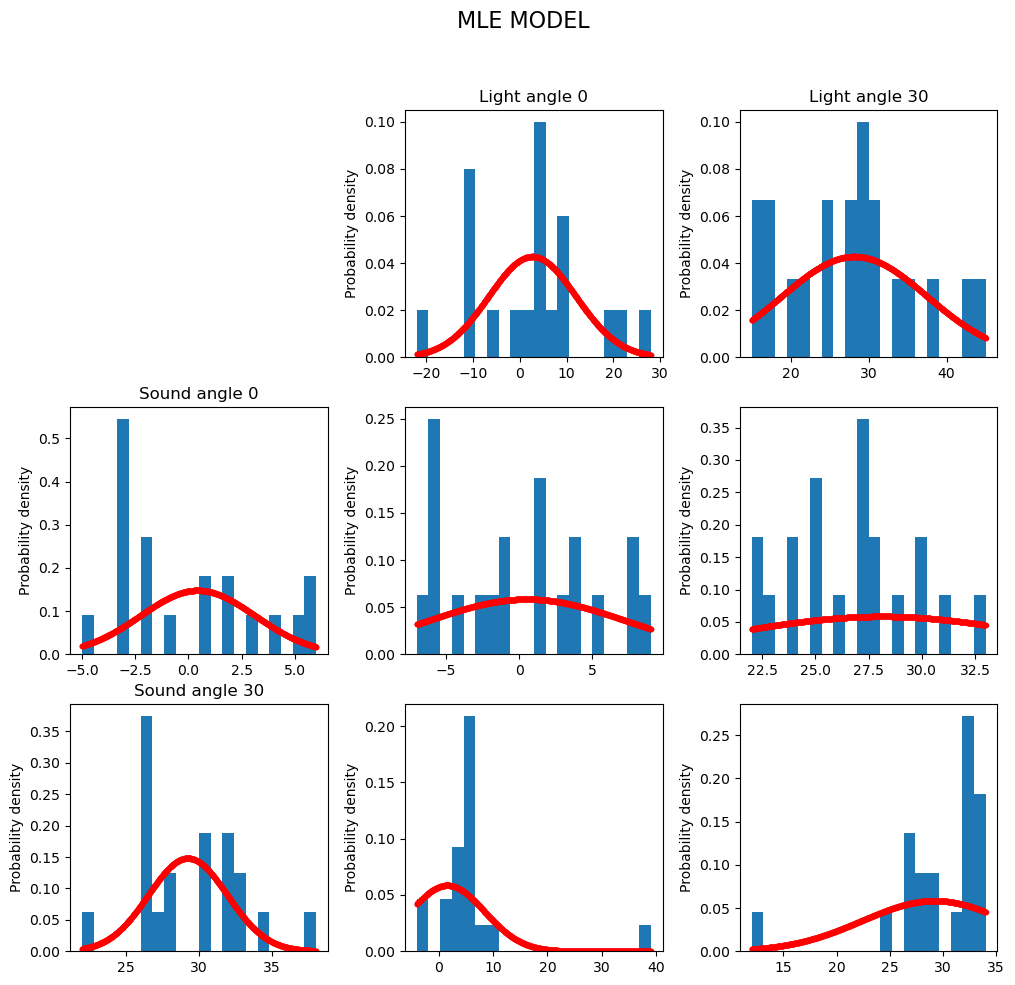

In [21]:
###-------------------------------------------------------------------------------------------------------------------
#         optimizing parameters for MLE model  
###-------------------------------------------------------------------------------------------------------------------
sol = minimize(optimize_all_parameters, x, method="Nelder-Mead", options={"maxiter": 10000})
print(sol)
plot_curves(sol, "MLE MODEL")

 final_simplex: (array([[ 2.5337483 , 28.32202946,  0.3289587 , 29.20270988,  9.3309399 ,
         2.35475541,  3.53351557],
       [ 2.53383327, 28.32208585,  0.32896048, 29.20271975,  9.33094489,
         2.35475709,  3.53352637],
       [ 2.53378922, 28.32203708,  0.32896189, 29.20272374,  9.33093695,
         2.35475348,  3.53351816],
       [ 2.53379712, 28.32204605,  0.32895271, 29.20272499,  9.33090913,
         2.35475672,  3.53352007],
       [ 2.5337918 , 28.32208612,  0.32896376, 29.20272058,  9.330914  ,
         2.35475449,  3.53350272],
       [ 2.53380108, 28.32206976,  0.32896994, 29.20271222,  9.33092276,
         2.35475733,  3.53353728],
       [ 2.5338007 , 28.32200548,  0.32895544, 29.20270094,  9.33093764,
         2.35475883,  3.53350119],
       [ 2.53383098, 28.32205224,  0.32896107, 29.20271767,  9.33092522,
         2.35475882,  3.53350698]]), array([504.80092716, 504.80092716, 504.80092716, 504.80092716,
       504.80092717, 504.80092717, 504.80092717, 504.8

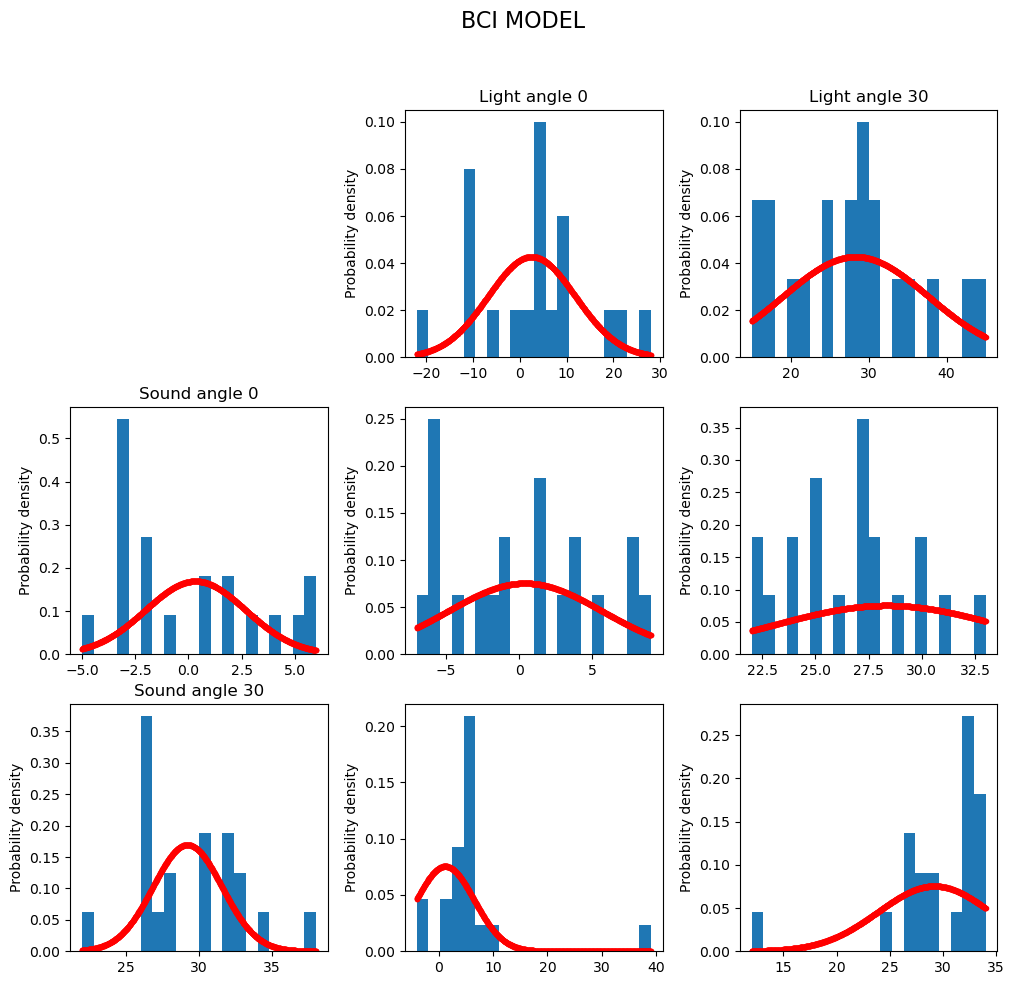

In [22]:
###-------------------------------------------------------------------------------------------------------------------
#         optimizing parameters for BCI model  
###-------------------------------------------------------------------------------------------------------------------
x.append(0.1)
sol = minimize(optimize_all_parameters_bci, x, method="Nelder-Mead", options={"maxiter": 10000})
print(sol)
plot_curves(sol, "BCI MODEL")
del x[-1]

In [49]:
print(1/(1 + np.exp(-3.53351557)))

0.9716264919944935


In [149]:
from scipy.stats import binom

###-------------------------------------------------------------------------------------------------------------------
#         Part 2 - MLE
# change it so that the sigmoid function - is the function above it and the parameters inside are as before 
###-------------------------------------------------------------------------------------------------------------------

###-------------------------------------------------------------------------------------------------------------------
#         Preparing data 
###-------------------------------------------------------------------------------------------------------------------

headers = ["d_b_sound", "d_b_visual", "1_visual_d_b_sound", "2_visual_d_b_sound", 
               "3_visual_d_b_sound", "4_visual_d_b_sound", "5_visual_d_b_sound"]

patients = ["Homework3pt2DataCSV1", "Homework3pt2DataCSV2", "Homework3pt2DataCSV3", 
            "Homework3pt2DataCSV4", "Homework3pt2DataCSV5"]


###-------------------------------------------------------------------------------------------------------------------
#         Iterating through each Patient
###-------------------------------------------------------------------------------------------------------------------

actual_data_response_arrays = np.array([])
model_data_response_arrays = np.array([])

for i in range(0, len(patients)):
    data_frame = pd.DataFrame()
    k = 0
    with open(patients[i] + '.csv') as csvfile:
        csv_reader = csv.reader(csvfile, delimiter=' ')
        for row in enumerate(csv_reader):
            row = [item for item in row if item != '']
            row = list(filter(None, row[1]))
            row = list(map(float, row))
            data_frame[headers[k]] = row
            k += 1

    list_a = [int(i) for i in list(data_frame.loc[:, "d_b_sound"])]
    list_b = [int(i) for i in list(data_frame.loc[:, "d_b_visual"])]
    observer_data = np.vstack([
        list_a,
        list_b,
        data_frame.loc[:, "1_visual_d_b_sound"],
        data_frame.loc[:, "2_visual_d_b_sound"],
        data_frame.loc[:, "3_visual_d_b_sound"],
        data_frame.loc[:, "4_visual_d_b_sound"],
        data_frame.loc[:, "5_visual_d_b_sound"]
        ])/24
            
    if len(actual_data_response_arrays) == 0:
        actual_data_response_arrays = observer_data.flatten()
    else:
        actual_data_response_arrays = np.vstack([
            actual_data_response_arrays,
            observer_data.flatten()
        ])
     
    ###-------------------------------------------------------------------------------------------------------------------
    #         Optimize MLE model for each Patient
    ###-------------------------------------------------------------------------------------------------------------------
    print("1. MLE MODEL OPTIMIZATION: ")
    x = [
         np.std(data_frame.loc[:, "d_b_sound"]),
         1,
         np.std(data_frame.loc[:, "d_b_visual"]),
         1
    ]
    sol = minimize(optimize_early_mle, x)#, method="Nelder-Mead")
    print(sol)

    if len(model_data_response_arrays) == 0:
        model_data_response_arrays = optimize_early_mle_response_probabilities(sol.x)
    else:
        model_data_response_arrays = np.vstack([model_data_response_arrays, optimize_early_mle_response_probabilities(sol.x)])

    ###-------------------------------------------------------------------------------------------------------------------
    #         Optimize BCI model for each Patient
    ###-------------------------------------------------------------------------------------------------------------------
    print("2. BCI MODEL OPTIMIZATION: ")
    x = [
         np.std(data_frame.loc[:, "d_b_sound"]),
         1,
         np.std(data_frame.loc[:, "d_b_visual"]),
         1,
         10
    ]
    sol = minimize(optimize_early_bci, x)
    print(sol)


    ###-------------------------------------------------------------------------------------------------------------------
    #         Optimize PROP MATCH Model for each Patient
    ###-------------------------------------------------------------------------------------------------------------------
    print("3. PROP MATCH MODEL OPTIMIZATION: ")
    x = [
        0.5,
        0.5,
        0.5,
        0.5,
        0.5,
        0.5,
        0.5,
        0.5,
        0.5,
        0.5
    ]
    sol = minimize(prob_matching_model, x)
    print(sol)
    
    if len(model_data_response_arrays) == 0:
        model_data_response_arrays = prob_matching_model_response_probabilities(sol.x)
    else:
        model_data_response_arrays = np.vstack([model_data_response_arrays, prob_matching_model_response_probabilities(sol.x)])

    ###-------------------------------------------------------------------------------------------------------------------
    #         Optimize PROP MATCH BCI Model for each Patient
    ###-------------------------------------------------------------------------------------------------------------------
    print("4. PROP MATCH BCI MODEL OPTIMIZATION: ")
    x = [
        0.5,
        0.5,
        0.5,
        0.5,
        0.5,
        0.5,
        0.5,
        0.5,
        0.5,
        0.5,
        20
    ]
    sol = minimize(prob_matching_model_c, x)
    print(sol)
        
    ###-------------------------------------------------------------------------------------------------------------------
    #         Optimize GAUSSIAN LATE MLE model for each Patient
    ###-------------------------------------------------------------------------------------------------------------------
    print("5. GAUSSIAN LATE MLE MODEL OPTIMIZATION: ")
    x = [
         np.std(data_frame.loc[:, "d_b_sound"]),
         1,
         np.std(data_frame.loc[:, "d_b_visual"]),
         1
    ]
    sol = minimize(gaussian_late_mle_model, x)
    print(sol)
    if len(model_data_response_arrays) == 0:
        model_data_response_arrays = gaussian_late_mle_model_response_probabilities(sol.x)
    else:
        model_data_response_arrays = np.vstack([model_data_response_arrays, gaussian_late_mle_model_response_probabilities(sol.x)])
    

    ###-------------------------------------------------------------------------------------------------------------------
    #         Optimize GAUSSIAN LATE MLE BCI model for each Patient
    ###-------------------------------------------------------------------------------------------------------------------
    print("6. GAUSSIAN LATE MLE BCI MODEL OPTIMIZATION: ")
    x = [
         np.std(data_frame.loc[:, "d_b_sound"]),
         1,
         np.std(data_frame.loc[:, "d_b_visual"]),
         1,
         0
    ]
    sol = minimize(gaussian_late_mle_model_c, x)#, bounds = bounds)#, method="Powell")
    print(sol)

5. GAUSSIAN LATE MLE MODEL OPTIMIZATION: 


/Users/eddyvonmatt/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[0.79259052 0.96183763 0.79157558 0.87384578]
5. GAUSSIAN LATE MLE MODEL OPTIMIZATION: 


/Users/eddyvonmatt/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/eddyvonmatt/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[0.77307639 0.95142291 0.68538307 0.88932532]
5. GAUSSIAN LATE MLE MODEL OPTIMIZATION: 
[0.75377105 0.9455909  0.84046881 0.89657294]
5. GAUSSIAN LATE MLE MODEL OPTIMIZATION: 


/Users/eddyvonmatt/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[0.69142408 0.96380426 0.85816666 0.96237767]
5. GAUSSIAN LATE MLE MODEL OPTIMIZATION: 


/Users/eddyvonmatt/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/eddyvonmatt/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[0.67116264 0.96445785 0.82550171 0.90266105]


In [ ]:
# ONLY USE ONE MODEL ABOVE (COMMENT EVERY OTHER MODEL OUT) to get the corresponding scatter plots
scatter_plot(actual_data_response_arrays, model_data_response_arrays)

In [138]:
###-------------------------------------------------------------------------------------------------------------------
#         EARLY MLE model
###-------------------------------------------------------------------------------------------------------------------
def optimize_early_mle(arguments): 
    sigma_a, c_a, sigma_v, c_v = arguments[0], arguments[1], arguments[2], arguments[3]
    log_error_sum = 0
    N = 24
    
    ###-------------------------------------------------------------------------------------------------------------------
    #         combined sigma and weight 
    ###-------------------------------------------------------------------------------------------------------------------
    w_0 = sigma_v ** 2 / (sigma_a ** 2 + sigma_v ** 2)
    sigma_combined_a_v = np.sqrt((w_0 ** 2) * (sigma_a ** 2) + ((1 - w_0) ** 2) * (sigma_v ** 2))
    
    ###-------------------------------------------------------------------------------------------------------------------
    #         intensity preparation
    ###----------------------------------------------------------------------------------------------------------------
    intensities = [1, 2, 3, 4, 5]
    
    v_s_intensities = np.vstack([
        data_frame.loc[:, "1_visual_d_b_sound"],
        data_frame.loc[:, "2_visual_d_b_sound"],
        data_frame.loc[:, "3_visual_d_b_sound"],
        data_frame.loc[:, "4_visual_d_b_sound"],
        data_frame.loc[:, "5_visual_d_b_sound"]
    ])
        
    for i, j in enumerate(intensities):
        n_a = int(data_frame.loc[:, "d_b_sound"][i])
        n_v = int(data_frame.loc[:, "d_b_visual"][i])
        p_a = norm.cdf((j - c_a) / sigma_a)
        p_v = norm.cdf((j - c_v) / sigma_v)

        log_error_sum += stats.binom.logpmf(n_a, N, p_a)
        log_error_sum += stats.binom.logpmf(n_v, N, p_v)

    for i, v in enumerate(intensities):
        for j, a in enumerate(intensities):
            n = int(v_s_intensities[i][j])
            I_a = a - c_a
            I_v = v - c_v
            I_a_v = w_0 * I_a + (1 - w_0) * I_v                                                           
            p = norm.cdf(I_a_v / sigma_combined_a_v)
            log_error_sum += np.log(stats.binom.pmf(n, N, p))            
    return -log_error_sum

###-------------------------------------------------------------------------------------------------------------------
#         EARLY MLE model response probabilities
###-------------------------------------------------------------------------------------------------------------------
def optimize_early_mle_response_probabilities(arguments): 
    sigma_a, c_a, sigma_v, c_v = arguments[0], arguments[1], arguments[2], arguments[3]
    log_error_sum = 0
    N = 24
    
    ###-------------------------------------------------------------------------------------------------------------------
    #         combined sigma and weight 
    ###-------------------------------------------------------------------------------------------------------------------
    w_0 = sigma_v ** 2 / (sigma_a ** 2 + sigma_v ** 2)
    sigma_combined_a_v = np.sqrt((w_0 ** 2) * (sigma_a ** 2) + ((1 - w_0) ** 2) * (sigma_v ** 2))
    
    ###-------------------------------------------------------------------------------------------------------------------
    #         intensity preparation
    ###----------------------------------------------------------------------------------------------------------------
    intensities = [1, 2, 3, 4, 5]
    
    v_s_intensities = np.vstack([
        data_frame.loc[:, "1_visual_d_b_sound"],
        data_frame.loc[:, "2_visual_d_b_sound"],
        data_frame.loc[:, "3_visual_d_b_sound"],
        data_frame.loc[:, "4_visual_d_b_sound"],
        data_frame.loc[:, "5_visual_d_b_sound"]
    ])
    
    model_response_probabilities_a = []
    model_response_probabilities_v = []
    for i, j in enumerate(intensities):
        n_a = int(data_frame.loc[:, "d_b_sound"][i])
        n_v = int(data_frame.loc[:, "d_b_visual"][i])
        p_a = norm.cdf((j - c_a) / sigma_a)
        p_v = norm.cdf((j - c_v) / sigma_v)

        log_error_sum += stats.binom.logpmf(n_a, N, p_a)
        log_error_sum += stats.binom.logpmf(n_v, N, p_v)
        
        model_response_probabilities_a.append(p_a)
        model_response_probabilities_v.append(p_v)

    model_response_probabilities_a_v = np.array([])
    for i, v in enumerate(intensities):
        response_probabilities_a_v = []
        for j, a in enumerate(intensities):
            n = int(v_s_intensities[i][j])
            I_a = a - c_a
            I_v = v - c_v
            I_a_v = w_0 * I_a + (1 - w_0) * I_v                                                           
            p = norm.cdf(I_a_v / sigma_combined_a_v)
            response_probabilities_a_v.append(p)
            log_error_sum += np.log(stats.binom.pmf(n, N, p))
        if len(model_response_probabilities_a_v) == 0:
            model_response_probabilities_a_v = response_probabilities_a_v
        else:
            model_response_probabilities_a_v = np.vstack([model_response_probabilities_a_v, response_probabilities_a_v])
    
    response_probabilities = np.vstack([
        model_response_probabilities_a,
        model_response_probabilities_v,
        model_response_probabilities_a_v
    ])
    return response_probabilities.flatten()


In [139]:
###-------------------------------------------------------------------------------------------------------------------
#        Early BCI model
###-------------------------------------------------------------------------------------------------------------------
def optimize_early_bci(arguments):
    sigma_a, c_a, sigma_v, c_v, c = arguments[0], arguments[1], arguments[2], arguments[3], arguments[4]
    log_error_sum = 0
    N = 24
    
    p_c = 1/(1 + np.exp(-c))

    ###-------------------------------------------------------------------------------------------------------------------
    #         combined sigma and weight 
    ###-------------------------------------------------------------------------------------------------------------------
    w_0 = sigma_v ** 2 / (sigma_a ** 2 + sigma_v ** 2)
    sigma_combined_a_v = np.sqrt((w_0 ** 2) * (sigma_a ** 2) + ((1 - w_0) ** 2) * (sigma_v ** 2))
    
    ###-------------------------------------------------------------------------------------------------------------------
    #         intensity preparation
    ###----------------------------------------------------------------------------------------------------------------
    intensities = [1, 2, 3, 4, 5]
    
    v_s_intensities = np.vstack([
        data_frame.loc[:, "1_visual_d_b_sound"],
        data_frame.loc[:, "2_visual_d_b_sound"],
        data_frame.loc[:, "3_visual_d_b_sound"],
        data_frame.loc[:, "4_visual_d_b_sound"],
        data_frame.loc[:, "5_visual_d_b_sound"]
    ])
        
    for i, j in enumerate(intensities):
        n_a = int(data_frame.loc[:, "d_b_sound"][i])
        n_v = int(data_frame.loc[:, "d_b_visual"][i])
        p_a = norm.cdf((j - c_a) / sigma_a)
        p_v = norm.cdf((j - c_v) / sigma_v)

        log_error_sum += stats.binom.logpmf(n_a, N, p_a)
        log_error_sum += stats.binom.logpmf(n_v, N, p_v)

    for i, v in enumerate(intensities):
        for j, a in enumerate(intensities):
            n = int(v_s_intensities[i][j])

            I_a = a - c_a
            I_v = v - c_v
            I_a_v = w_0 * I_a + (1 - w_0) * I_v 
            
            p = norm.cdf(I_a_v / sigma_combined_a_v)
            p_a = norm.cdf((I_a - c_a)/sigma_a)
            
            audiovisual = stats.binom.pmf(n, N, p)
            only_sound = stats.binom.pmf(n, N, p_a)

            log_error_sum += np.log(audiovisual * p_c + only_sound * (1 - p_c))
    return -log_error_sum

In [140]:
###-------------------------------------------------------------------------------------------------------------------
#        Prob Matching model 
###-------------------------------------------------------------------------------------------------------------------
def prob_matching_model(arguments): 
    a_array = [arguments[0], arguments[1], arguments[2], arguments[3], arguments[4]]
    v_array = [arguments[5], arguments[6], arguments[7], arguments[8], arguments[9]]
    log_error_sum = 0
    N = 24
    
    for i in range(0, len(a_array)):
        a_array[i] = 1/(1 + math.exp(-a_array[i]))
        v_array[i] = 1/(1 + math.exp(-v_array[i]))
    
    ###-------------------------------------------------------------------------------------------------------------------
    #         intensity preparation
    ###-------------------------------------------------------------------------------------------------------------------
    intensities = [1, 2, 3, 4, 5]
    
    v_s_intensities = np.vstack([
        data_frame.loc[:, "1_visual_d_b_sound"],
        data_frame.loc[:, "2_visual_d_b_sound"],
        data_frame.loc[:, "3_visual_d_b_sound"],
        data_frame.loc[:, "4_visual_d_b_sound"],
        data_frame.loc[:, "5_visual_d_b_sound"]
    ])
        
    for i, j in enumerate(intensities):
        n_a = int(data_frame.loc[:, "d_b_sound"][i])
        n_v = int(data_frame.loc[:, "d_b_visual"][i])
        p_a = a_array[i]
        p_v = v_array[i]
        log_error_sum += stats.binom.logpmf(n_a, N, p_a)
        log_error_sum += stats.binom.logpmf(n_v, N, p_v)
    
    for i, v in enumerate(intensities):
        for j, a in enumerate(intensities):
            n = int(v_s_intensities[i][j])
            p_a = a_array[j]
            p_v = v_array[i]
            p = (p_a * p_v)/((p_a * p_v) + (1 - p_a) * (1 - p_v))
            log_error_sum += stats.binom.logpmf(n, N, p)
    return -log_error_sum

###-------------------------------------------------------------------------------------------------------------------
#        Prob Matching model 
###-------------------------------------------------------------------------------------------------------------------
def prob_matching_model_response_probabilities(arguments): 
    a_array = [arguments[0], arguments[1], arguments[2], arguments[3], arguments[4]]
    v_array = [arguments[5], arguments[6], arguments[7], arguments[8], arguments[9]]
    log_error_sum = 0
    N = 24
    
    for i in range(0, len(a_array)):
        a_array[i] = 1/(1 + math.exp(-a_array[i]))
        v_array[i] = 1/(1 + math.exp(-v_array[i]))
    
    ###-------------------------------------------------------------------------------------------------------------------
    #         intensity preparation
    ###-------------------------------------------------------------------------------------------------------------------
    intensities = [1, 2, 3, 4, 5]
    
    v_s_intensities = np.vstack([
        data_frame.loc[:, "1_visual_d_b_sound"],
        data_frame.loc[:, "2_visual_d_b_sound"],
        data_frame.loc[:, "3_visual_d_b_sound"],
        data_frame.loc[:, "4_visual_d_b_sound"],
        data_frame.loc[:, "5_visual_d_b_sound"]
    ])
    
    model_response_probabilities_a = []
    model_response_probabilities_v = []
    for i, j in enumerate(intensities):
        n_a = int(data_frame.loc[:, "d_b_sound"][i])
        n_v = int(data_frame.loc[:, "d_b_visual"][i])
        p_a = a_array[i]
        p_v = v_array[i]
        log_error_sum += stats.binom.logpmf(n_a, N, p_a)
        log_error_sum += stats.binom.logpmf(n_v, N, p_v)
        model_response_probabilities_a.append(p_a)
        model_response_probabilities_v.append(p_v)
        
    model_response_probabilities_a_v = np.array([])
    for i, v in enumerate(intensities):
        response_probabilities_a_v = []
        for j, a in enumerate(intensities):
            n = int(v_s_intensities[i][j])
            p_a = a_array[j]
            p_v = v_array[i]
            p = (p_a * p_v)/((p_a * p_v) + (1 - p_a) * (1 - p_v))
            
            log_error_sum += stats.binom.logpmf(n, N, p)
            
            response_probabilities_a_v.append(p)

        if len(model_response_probabilities_a_v) == 0:
            model_response_probabilities_a_v = response_probabilities_a_v
        else:
            model_response_probabilities_a_v = np.vstack([model_response_probabilities_a_v, response_probabilities_a_v])
    
    response_probabilities = np.vstack([
        model_response_probabilities_a,
        model_response_probabilities_v,
        model_response_probabilities_a_v
    ])
    return response_probabilities.flatten()
    

In [141]:
###-------------------------------------------------------------------------------------------------------------------
#        Prob Matching BCI model
###-------------------------------------------------------------------------------------------------------------------
def prob_matching_model_c(arguments): 
    a_array = [arguments[0], arguments[1], arguments[2], arguments[3], arguments[4]]
    v_array = [arguments[5], arguments[6], arguments[7], arguments[8], arguments[9]]
    c = arguments[10]
    log_error_sum = 0
    N = 24
    
    p_c = 1/(1 + np.exp(-c))
    
    for i in range(0, len(a_array)):
        a_array[i] = 1/(1 + math.exp(-a_array[i]))
        v_array[i] = 1/(1 + math.exp(-v_array[i]))
    
    ###-------------------------------------------------------------------------------------------------------------------
    #         intensity preparation
    ###-------------------------------------------------------------------------------------------------------------------
    intensities = [1, 2, 3, 4, 5]
    
    v_s_intensities = np.vstack([
        data_frame.loc[:, "1_visual_d_b_sound"],
        data_frame.loc[:, "2_visual_d_b_sound"],
        data_frame.loc[:, "3_visual_d_b_sound"],
        data_frame.loc[:, "4_visual_d_b_sound"],
        data_frame.loc[:, "5_visual_d_b_sound"]
    ])
        
    for i, j in enumerate(intensities):
        n_a = int(data_frame.loc[:, "d_b_sound"][i])
        n_v = int(data_frame.loc[:, "d_b_visual"][i])
        p_a = a_array[i]
        p_v = v_array[i]
        log_error_sum += stats.binom.logpmf(n_a, N, p_a)
        log_error_sum += stats.binom.logpmf(n_v, N, p_v)
    
    for i, v in enumerate(intensities):
        for j, a in enumerate(intensities):
            n = int(v_s_intensities[i][j])
            p_a = a_array[j]
            p_v = v_array[i]
            p = (p_a * p_v)/((p_a * p_v) + (1 - p_a) * (1 - p_v))
            audiovisual = stats.binom.pmf(n, N, p)
            only_audio = stats.binom.pmf(n, N, p_a)
            log_error_sum += np.log(audiovisual * p_c + only_audio * (1 - p_c))
    return -log_error_sum


In [148]:
###-------------------------------------------------------------------------------------------------------------------
#        Gaussian Late MLE model
###-------------------------------------------------------------------------------------------------------------------
def gaussian_late_mle_model(arguments): 
    sigma_a, c_a, sigma_v, c_v = arguments[0], arguments[1], arguments[2], arguments[3]
    log_error_sum = 0
    N = 24
    
    
    
    ###-------------------------------------------------------------------------------------------------------------------
    #         combined sigma and weight 
    ###-------------------------------------------------------------------------------------------------------------------
    w_0 = sigma_v ** 2 / (sigma_a ** 2 + sigma_v**2)
    
    ###-------------------------------------------------------------------------------------------------------------------
    #         intensity preparation
    ###----------------------------------------------------------------------------------------------------------------
    intensities = [1, 2, 3, 4, 5]
    
    v_s_intensities = np.vstack([
        data_frame.loc[:, "1_visual_d_b_sound"],
        data_frame.loc[:, "2_visual_d_b_sound"],
        data_frame.loc[:, "3_visual_d_b_sound"],
        data_frame.loc[:, "4_visual_d_b_sound"],
        data_frame.loc[:, "5_visual_d_b_sound"]
    ])
        
    for i, j in enumerate(intensities):
        n_a = int(data_frame.loc[:, "d_b_sound"][i])
        n_v = int(data_frame.loc[:, "d_b_visual"][i])
        p_a = norm.cdf((j - c_a) / sigma_a)
        p_v = norm.cdf((j - c_v) / sigma_v)
        log_error_sum += stats.binom.logpmf(n_a, N, p_a)
        log_error_sum += stats.binom.logpmf(n_v, N, p_v)
    
    for i, v in enumerate(intensities):
        for j, a in enumerate(intensities):
            n = int(v_s_intensities[i][j])
            p_a = norm.cdf((a - c_a) / sigma_a)
            p_v = norm.cdf((v - c_v) / sigma_v)                                          
            p = (p_a * p_v)/((p_a * p_v) + (1 - p_a) * (1 - p_v))
            log_error_sum += stats.binom.logpmf(n, N, p)
    return -log_error_sum

###-------------------------------------------------------------------------------------------------------------------
#        Gaussian Late MLE model
###-------------------------------------------------------------------------------------------------------------------
def gaussian_late_mle_model_response_probabilities(arguments): 
    sigma_a, c_a, sigma_v, c_v = arguments[0], arguments[1], arguments[2], arguments[3]
    log_error_sum = 0
    N = 24
    
    
    
    ###-------------------------------------------------------------------------------------------------------------------
    #         combined sigma and weight 
    ###-------------------------------------------------------------------------------------------------------------------
    w_0 = sigma_v ** 2 / (sigma_a ** 2 + sigma_v**2)
    
    ###-------------------------------------------------------------------------------------------------------------------
    #         intensity preparation
    ###----------------------------------------------------------------------------------------------------------------
    intensities = [1, 2, 3, 4, 5]
    
    v_s_intensities = np.vstack([
        data_frame.loc[:, "1_visual_d_b_sound"],
        data_frame.loc[:, "2_visual_d_b_sound"],
        data_frame.loc[:, "3_visual_d_b_sound"],
        data_frame.loc[:, "4_visual_d_b_sound"],
        data_frame.loc[:, "5_visual_d_b_sound"]
    ])
    
    model_response_probabilities_a = []
    model_response_probabilities_v = []
        
    for i, j in enumerate(intensities):
        n_a = int(data_frame.loc[:, "d_b_sound"][i])
        n_v = int(data_frame.loc[:, "d_b_visual"][i])
        p_a = norm.cdf((j - c_a) / sigma_a)
        p_v = norm.cdf((j - c_v) / sigma_v)
        log_error_sum += stats.binom.logpmf(n_a, N, p_a)
        log_error_sum += stats.binom.logpmf(n_v, N, p_v)
        
        model_response_probabilities_a.append(p_a)
        model_response_probabilities_v.append(p_v)
    
    model_response_probabilities_a_v = np.array([])
    for i, v in enumerate(intensities):
        response_probabilities_a_v = []
        for j, a in enumerate(intensities):
            n = int(v_s_intensities[i][j])
            p_a = norm.cdf((a - c_a) / sigma_a)
            p_v = norm.cdf((v - c_v) / sigma_v)                                          
            p = (p_a * p_v)/((p_a * p_v) + (1 - p_a) * (1 - p_v))
            log_error_sum += stats.binom.logpmf(n, N, p)
            response_probabilities_a_v.append(p)

        if len(model_response_probabilities_a_v) == 0:
            model_response_probabilities_a_v = response_probabilities_a_v
        else:
            model_response_probabilities_a_v = np.vstack([model_response_probabilities_a_v, response_probabilities_a_v])
    
    response_probabilities = np.vstack([
        model_response_probabilities_a,
        model_response_probabilities_v,
        model_response_probabilities_a_v
    ])
    return response_probabilities.flatten()

In [143]:
###-------------------------------------------------------------------------------------------------------------------
#        Gaussian Late MLE BCI model 
###-------------------------------------------------------------------------------------------------------------------
def gaussian_late_mle_model_c(arguments): 
    sigma_a, c_a, sigma_v, c_v, c = arguments[0], arguments[1], arguments[2], arguments[3], arguments[4]
    log_error_sum = 0
    N = 24
    
    p_c = 1/(1 + np.exp(-c))

    ###-------------------------------------------------------------------------------------------------------------------
    #         combined sigma and weight 
    ###-------------------------------------------------------------------------------------------------------------------
    w_0 = sigma_v ** 2 / (sigma_a ** 2 + sigma_v**2)
    
    ###-------------------------------------------------------------------------------------------------------------------
    #         intensity preparation
    ###----------------------------------------------------------------------------------------------------------------
    intensities = [1, 2, 3, 4, 5]
    
    v_s_intensities = np.vstack([
        data_frame.loc[:, "1_visual_d_b_sound"],
        data_frame.loc[:, "2_visual_d_b_sound"],
        data_frame.loc[:, "3_visual_d_b_sound"],
        data_frame.loc[:, "4_visual_d_b_sound"],
        data_frame.loc[:, "5_visual_d_b_sound"]
    ])
        
    for i, j in enumerate(intensities):
        n_a = int(data_frame.loc[:, "d_b_sound"][i])
        n_v = int(data_frame.loc[:, "d_b_visual"][i])
        p_a = norm.cdf((j - c_a) / sigma_a)
        p_v = norm.cdf((j - c_v) / sigma_v)
        log_error_sum += stats.binom.logpmf(n_a, N, p_a)
        log_error_sum += stats.binom.logpmf(n_v, N, p_v)
    
    for i, v in enumerate(intensities):
        for j, a in enumerate(intensities):
            n = int(v_s_intensities[i][j])
            p_a = norm.cdf((a - c_a) / sigma_a)
            p_v = norm.cdf((v - c_v) / sigma_v)                                          
            p = (p_a * p_v)/((p_a * p_v) + (1 - p_a) * (1 - p_v))
            audiovisual = stats.binom.pmf(n, N, p)
            only_visual = stats.binom.pmf(n, N, p_a)
            log_error_sum += np.log(audiovisual * p_c + only_visual * (1 - p_c))
    return -log_error_sum

[0.         0.08333333 0.16666667 1.         1.         0.
 0.70833333 1.         1.         1.         0.         0.
 0.         0.41666667 0.58333333 0.16666667 0.33333333 0.29166667
 0.83333333 0.91666667 0.375      0.625      0.79166667 1.
 1.         0.58333333 0.70833333 0.91666667 1.         1.
 0.58333333 0.79166667 0.95833333 1.         1.        ]
[0.00548268 0.07104937 0.4335121  0.69842311 0.96434142 0.22583603
 0.51318375 0.88440054 0.99245088 0.99983424 0.00673708 0.04419681
 0.1744098  0.43257201 0.72482036 0.05228979 0.19361465 0.45768805
 0.74284232 0.92080779 0.21152637 0.48217268 0.76168513 0.92897078
 0.98694607 0.48951377 0.77200102 0.93539114 0.98895844 0.99889581
 0.76908621 0.93853063 0.99059486 0.99920021 0.99996295]
[0.04166667 0.125      0.45833333 1.         1.         0.
 0.79166667 1.         1.         1.         0.         0.
 0.         0.08333333 0.375      0.125      0.33333333 0.54166667
 0.875      1.         0.33333333 0.75       1.         1.
 1. 

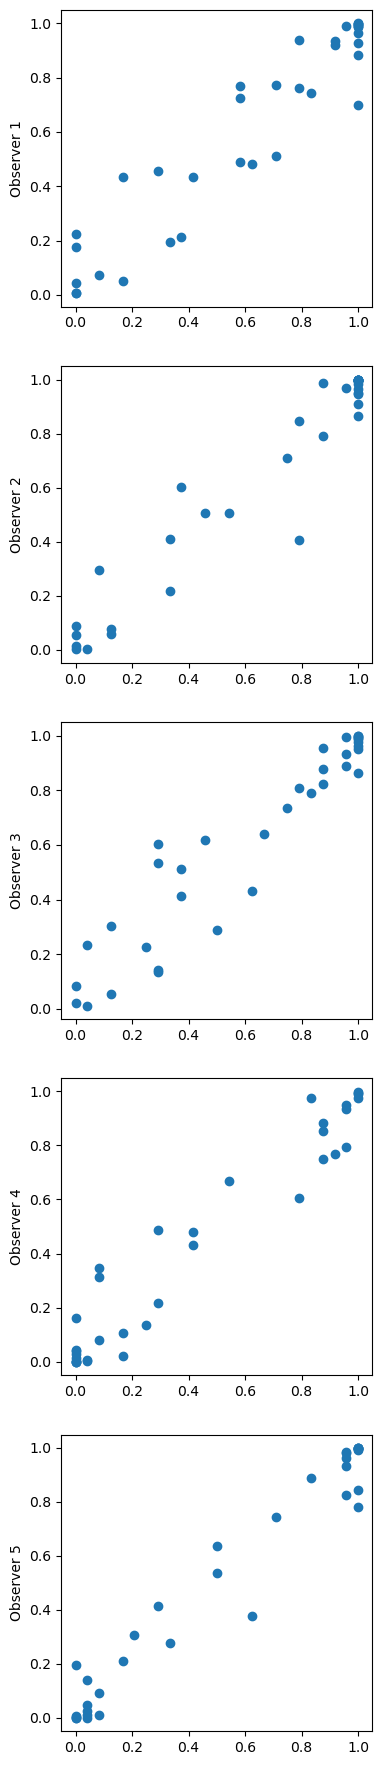

In [158]:
# Integration of Cross Validation Data from Támás

p_value = [0.006737082106901282, 0.044196807546718966, 0.17440979725089878, 0.43257201476509516, 0.724820362790225, 0.05228979266559955, 0.19361465016389812, 0.4576880475861952, 0.7428423182221733, 0.9208077886756851, 0.2115263749809545, 0.4821726837182751, 0.7616851256056546, 0.9289707795329116, 0.9869460667763793, 0.4895137672221786, 0.7720010220171962, 0.9353911416138835, 0.9889584359746385, 0.9988958106189774, 0.7690862115836787, 0.9385306264324259, 0.9905948562599497, 0.9992002113116756, 0.9999629462717549]
p_a_value = [0.005482677390769031, 0.07104937342593697, 0.43351210194993367, 0.6984231110329102, 0.9643414221885981]
p_v_value = [0.22583603415748676, 0.513183753704741, 0.8844005405225988, 0.9924508759351517, 0.9998342366396027]
combined_observer = np.concatenate((p_a_value, p_v_value, p_value))

model_data_response_arrays = combined_observer

p_value = [0.00162110605685946, 0.01605273117321243, 0.08973293187957726, 0.29400990763092105, 0.6021769218766273, 0.05753630964171624, 0.21713717120019288, 0.5047873058923058, 0.7898494190485028, 0.9451782386457876, 0.4093041710053389, 0.7112864208000079, 0.9104657741844602, 0.9834187680048116, 0.9982306132267537, 0.8473715917303273, 0.9673170402828734, 0.996096087554659, 0.999747217904728, 0.9999912776356908, 0.989204888362057, 0.9992872352735942, 0.9999776137396923, 0.9999996708746246, 0.999999997757362]
p_a_value = [0.0022713566495392926, 0.07880117805556236, 0.5056817137939847, 0.8637942309412681, 0.9950628420344289]
p_v_value = [0.056784866245483075, 0.40676319215233236, 0.9518649567325324, 0.9658452538325968, 0.9999998628694519]
combined_observer = np.concatenate((p_a_value, p_v_value, p_value))


model_data_response_arrays = np.vstack([model_data_response_arrays, combined_observer])

p_value = [0.011930301604807764, 0.08264923312750277, 0.3030760623997392, 0.6392004772211773, 0.8903175830721406, 0.05489900395204385, 0.22460903570803614, 0.5341329093659158, 0.8233080422780853, 0.9616720684685259, 0.14042905860741933, 0.412012410653446, 0.7368456876906244, 0.9318449199492352, 0.9905041948742722, 0.2902834129220797, 0.619072229551395, 0.8766999534741872, 0.9780083018433335, 0.9979466736834786, 0.5127073439008025, 0.8073562234454584, 0.9558591436810157, 0.9944711369664592, 0.9996338695311354]
p_a_value = [0.019606236473545195, 0.13447041400404153, 0.6015100134249912, 0.8633000898629755, 0.9888194951423328]
p_v_value = [0.23311360116724522, 0.4325591213963203, 0.7908100279198941, 0.951391265999522, 0.9967397159556094]
combined_observer = np.concatenate((p_a_value, p_v_value, p_value))

model_data_response_arrays = np.vstack([model_data_response_arrays, combined_observer])

p_value = [5.72571634440345e-05, 0.0042624751061929225, 0.0802343713577987, 0.42996853295875037, 0.8532761308589984, 0.0002319292333596359, 0.012372488806355764, 0.16110695551487136, 0.6046969528129729, 0.935865801330992, 0.0016148070206212317, 0.04297886427389546, 0.3123354707247179, 0.7699356566946242, 0.9753802012431266, 0.0064636670411545175, 0.10422881455479421, 0.4880850204088217, 0.8845563124119866, 0.9923673518389711, 0.022398236593063652, 0.21543619935921693, 0.6668244294813217, 0.9505307952933493, 0.9979403795059171]
p_a_value = [0.0003506285394121384, 0.027618233264821893, 0.34539202982245243, 0.7956301101906968, 0.9903895305636005]
p_v_value = [0.03839970272080025, 0.13740601355271875, 0.4795369658588748, 0.7511841446228773, 0.9750496793091945]
combined_observer = np.concatenate((p_a_value, p_v_value, p_value))

model_data_response_arrays = np.vstack([model_data_response_arrays, combined_observer])

p_value = [3.675735419703107e-05, 0.0057772130939561794, 0.13866829367591066, 0.6378899041437979, 0.9634311510289999, 0.00037464183010165104, 0.02637859402402122, 0.3075082301129374, 0.8240865546004772, 0.9909856681084578, 0.00307031436831381, 0.0928907878093071, 0.5373868049447659, 0.9345887844626963, 0.9982935960740527, 0.011336831305731512, 0.20874211243285934, 0.7445065865606981, 0.9832232638905991, 0.9998368626621769, 0.04847183767896207, 0.4141994493306122, 0.8899653315184655, 0.996201141966214, 0.9999804337124151]
p_a_value = [3.742586733419519e-05, 0.010043666596344475, 0.27852869210112496, 0.8444245638484289, 0.997791940185201]
p_v_value = [0.1947638998348431, 0.37721949136614275, 0.7811580073668662, 0.9842244068120507, 0.9992029602677206]
combined_observer = np.concatenate((p_a_value, p_v_value, p_value))

model_data_response_arrays = np.vstack([model_data_response_arrays, combined_observer])


scatter_plot(actual_data_response_arrays, model_data_response_arrays)



[0.         0.08333333 0.16666667 1.         1.         0.
 0.70833333 1.         1.         1.         0.         0.
 0.         0.41666667 0.58333333 0.16666667 0.33333333 0.29166667
 0.83333333 0.91666667 0.375      0.625      0.79166667 1.
 1.         0.58333333 0.70833333 0.91666667 1.         1.
 0.58333333 0.79166667 0.95833333 1.         1.        ]
[0.0396727  0.09418254 0.18719914 0.86268224 0.94654609 0.06636186
 0.69001567 0.93820405 0.96992523 0.97666031 0.00188501 0.0051875
 0.01118847 0.37426944 0.56030377 0.07810441 0.19088648 0.33689352
 0.96363572 0.98255215 0.40020887 0.64846693 0.80249186 0.9951115
 0.99768268 0.56737037 0.78420328 0.88777019 0.99671865 0.99924512
 0.62563095 0.82233502 0.90958692 0.99834324 0.99876583]
[0.04166667 0.125      0.45833333 1.         1.         0.
 0.79166667 1.         1.         1.         0.         0.
 0.         0.08333333 0.375      0.125      0.33333333 0.54166667
 0.875      1.         0.33333333 0.75       1.         1.
 1.   

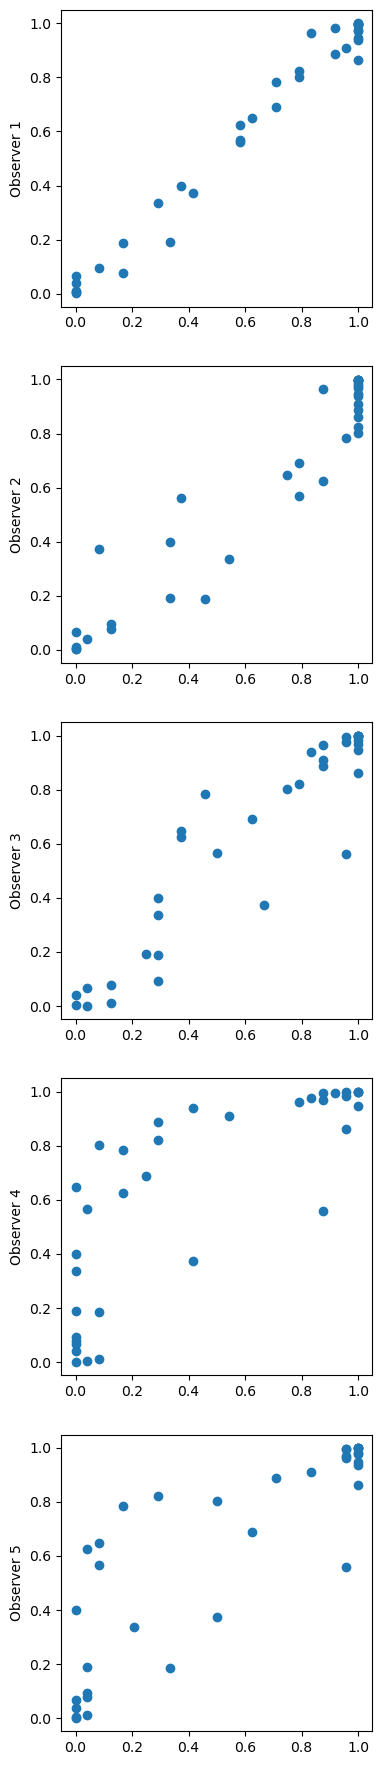

In [161]:
p_value = [0.001885011454300406, 0.005187498970351707, 0.011188465384739535, 0.3742694352422467, 0.5603037706140745, 0.07810440877482915, 0.1908864751762603, 0.3368935221805084, 0.9636357186509567, 0.9825521492141319, 0.4002088686595812, 0.6484669340010077, 0.8024918618573146, 0.9951114974742414, 0.9976826827027476, 0.5673703676071425, 0.7842032754867736, 0.8877701885906204, 0.9967186548238179, 0.9992451209851748, 0.625630945522681, 0.8223350216496353, 0.9095869198590113, 0.9983432392716562, 0.9987658287134709]
p_a_value = [0.039672704287904426, 0.09418254073794978, 0.18719914271391627, 0.8626822400222262, 0.9465460873842685]
p_v_value = [0.06636185647046666, 0.6900156657379272, 0.9382040490956115, 0.9699252323971077, 0.9766603057641626]
combined_observer = np.concatenate((p_a_value, p_v_value, p_value))

model_data_response_arrays = combined_observer

p_value:  [0.00012681195661018785, 0.0008077544841460913, 0.003634284268374083, 0.062315289529232994, 0.38655395530219894, 0.05882821545947187, 0.2852098231569268, 0.642487475979041, 0.9702325489184017, 0.9967521633693608, 0.3816595826139405, 0.797335238361689, 0.9470015633673764, 0.9968409523834915, 0.9996532488217472, 0.8023421863107275, 0.9628224527386732, 0.9915582076117391, 0.9994280159517547, 0.9999999998057276, 0.8992012699371841, 0.9827229883259044, 0.9961144952560036, 0.9997667602333564, 0.9999999999874871]
p_a_value:  [0.022199023549365586, 0.14594276054076893, 0.3650121948191919, 0.8149414229379071, 0.990494240579505]
p_v_value:  [0.005506796509277558, 0.6463962880931192, 0.9528721172280187, 0.9935167827129863, 0.997090198637348]
combined_observer = np.concatenate((p_a_value, p_v_value, p_value))


model_data_response_arrays = np.vstack([model_data_response_arrays, combined_observer])

p_value:  [0.008007430699914626, 0.020475377124762672, 0.056956097974814, 0.6391496366652127, 0.9671221764476063, 0.08428140774868301, 0.1890303321251801, 0.39220136558196295, 0.9434525479787308, 0.9962929649575688, 0.25039900915528596, 0.4537617468623442, 0.6892565918505806, 0.987411378103327, 0.9992524590080597, 0.43124254056971184, 0.6523737099507566, 0.8433429031668456, 0.9923528883092236, 0.9996077253797052, 0.4934773310848371, 0.7066826776457459, 0.8731709789122382, 0.9945894582697287, 0.9999999991807875]
p_a_value:  [0.07777132686020405, 0.10903429115286753, 0.35876723361123236, 0.9042486892331283, 0.9949211025455461]
p_v_value:  [0.17154129588460826, 0.5135028548475226, 0.8197296971070532, 0.8927579813416128, 0.9267847278907194]
combined_observer = np.concatenate((p_a_value, p_v_value, p_value))


model_data_response_arrays = np.vstack([model_data_response_arrays, combined_observer])

p_value:  [0.0013343069788759913, 0.003628067096394745, 0.010433549958740261, 0.4357669169480167, 0.8917624357907166, 0.004609579664095852, 0.011408149577407154, 0.035898890244422076, 0.7493069957644556, 0.9707785423629383, 0.011103126698233, 0.030040539674764062, 0.07490142381522408, 0.8878455990524181, 0.9892416930496042, 0.05417746335574131, 0.13584693318328508, 0.31277396083196884, 0.9724071694770171, 0.9969634514510652, 0.11994000351612964, 0.2722318820584794, 0.5200039510063134, 0.987346077625008, 0.9991704343946992]
p_a_value:  [0.018029699391707822, 0.05126777720061895, 0.1257488015313841, 0.8881600433768728, 0.9893752762683]
p_v_value:  [0.10885928210633183, 0.2142162777435306, 0.4337701430146011, 0.693168606150461, 0.914653771135485]
combined_observer = np.concatenate((p_a_value, p_v_value, p_value))


model_data_response_arrays = np.vstack([model_data_response_arrays, combined_observer])

p_value:  [0.00021728589734192657, 0.0009773926418655313, 0.01190979980514129, 0.4776726969521593, 0.9621682900183833, 0.006640189355095967, 0.02930629123055785, 0.2706206588605083, 0.9655431261115376, 0.9987170304569649, 0.024058645566860028, 0.10009906706502798, 0.5721552940238667, 0.9923642807793179, 0.9997368531521179, 0.04700139177017548, 0.18189805798738198, 0.73314478228797, 0.9941205054100982, 0.9998860237347914, 0.08440745397425188, 0.2935774655470673, 0.8365956032186593, 0.9973817041332034, 0.9999999998242314]
p_a_value:  [0.004523369347172252, 0.017539171606723948, 0.13099946045868052, 0.9201650222615964, 0.9979283994912398]
p_v_value:  [0.07546940592875781, 0.574081245242692, 0.7301263598432421, 0.9029178432827343, 0.9439977332397192]
combined_observer = np.concatenate((p_a_value, p_v_value, p_value))


model_data_response_arrays = np.vstack([model_data_response_arrays, combined_observer])

scatter_plot(actual_data_response_arrays, model_data_response_arrays)


[0.         0.08333333 0.16666667 1.         1.         0.
 0.70833333 1.         1.         1.         0.         0.
 0.         0.41666667 0.58333333 0.16666667 0.33333333 0.29166667
 0.83333333 0.91666667 0.375      0.625      0.79166667 1.
 1.         0.58333333 0.70833333 0.91666667 1.         1.
 0.58333333 0.79166667 0.95833333 1.         1.        ]
[0.05381715 0.19614187 0.48793753 0.64310861 0.88429909 0.33909671
 0.46731186 0.75311063 0.93342338 0.98873628 0.01658091 0.06705768
 0.19835914 0.4500523  0.75617563 0.05633355 0.20034629 0.46039603
 0.73636715 0.91258216 0.17178757 0.4651622  0.7474628  0.90638806
 0.97308085 0.43803633 0.77181292 0.92179525 0.9752679  0.99345574
 0.80344539 0.95151177 0.98658805 0.99625955 0.99913528]
[0.04166667 0.125      0.45833333 1.         1.         0.
 0.79166667 1.         1.         1.         0.         0.
 0.         0.08333333 0.375      0.125      0.33333333 0.54166667
 0.875      1.         0.33333333 0.75       1.         1.
 1. 

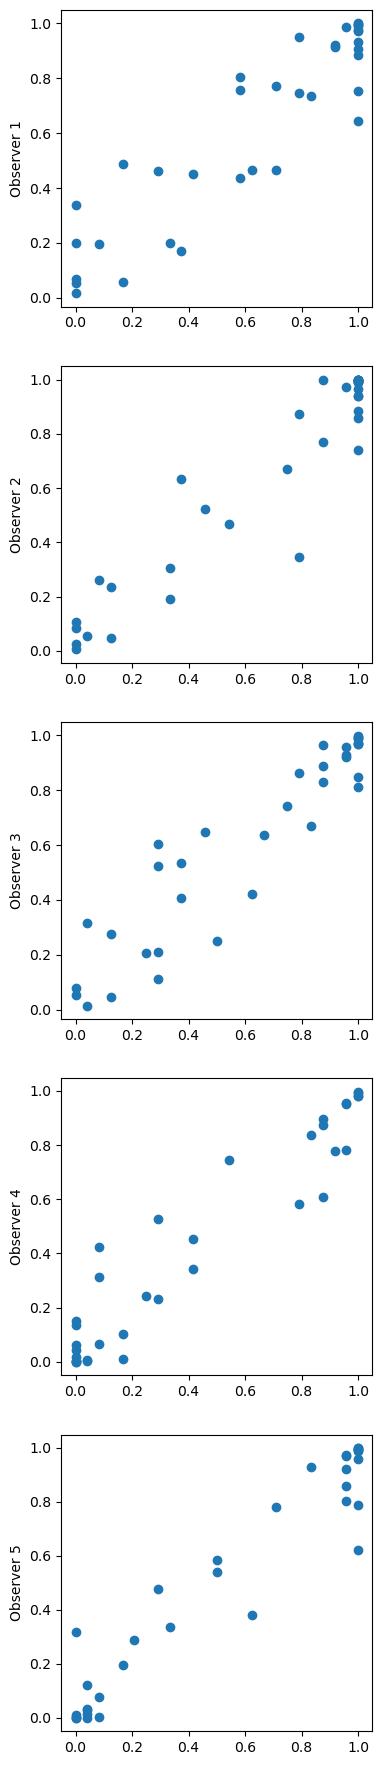

In [159]:
p_value=  [0.016580908207773023, 0.06705767733714113, 0.1983591422618445, 0.450052300482513, 0.7561756271350147, 0.056333550463870834, 0.20034629458791625, 0.46039603196561313, 0.7363671522157822, 0.9125821601580637, 0.17178757116037183, 0.4651621979417897, 0.7474627977339245, 0.9063880631696701, 0.9730808514700756, 0.4380363263438287, 0.7718129153742306, 0.9217952482323807, 0.9752678982975249, 0.9934557397239487, 0.8034453905263, 0.9515117695485817, 0.9865880503587231, 0.9962595532744232, 0.9991352844136793]
p_a_value= [0.05381715160385589, 0.1961418731974382, 0.48793752861693707, 0.6431086101665323, 0.8842990896561044]
p_v_value=  [0.3390967093789765, 0.46731185779550005, 0.7531106343787031, 0.9334233837352626, 0.9887362783557188]
combined_observer = np.concatenate((p_a_value, p_v_value, p_value))

model_data_response_arrays = combined_observer
    
p_value=  [0.005147899831569161, 0.024009608851789762, 0.08538640354453907, 0.2627513726190325, 0.6328668861796668, 0.04761479181148205, 0.19022029342639474, 0.46922565217402806, 0.7697950401604944, 0.9409900783167592, 0.3047619045590258, 0.6698169926414776, 0.882989282483181, 0.9656803720328803, 0.9924313304356197, 0.8747858919379822, 0.9710727540786301, 0.9922538725361947, 0.9979633307643556, 0.9995784692914059, 0.9975859160339459, 0.9996128362379736, 0.9999156127972564, 0.9999822311237191, 0.9999974227111509]
p_a_value=  [0.05567919020599033, 0.2357966471008044, 0.5216520547254471, 0.7415710862018299, 0.9411029324872395]
p_v_value= [0.10728666319848013, 0.34651737545665545, 0.8592582425000883, 0.9927929498027094, 0.99990971764984]
combined_observer = np.concatenate((p_a_value, p_v_value, p_value))


model_data_response_arrays = np.vstack([model_data_response_arrays, combined_observer])

    
p_value=  [0.015066907836254303, 0.08060752568821117, 0.2770275559131801, 0.6367437632860757, 0.919732315485279, 0.04661835478631501, 0.20823591356103321, 0.5244077953290402, 0.8283914727252613, 0.967129434279689, 0.11123203692105871, 0.40662236999336876, 0.7442347944241106, 0.928249659950848, 0.9877888045197055, 0.24932231862928766, 0.6484520035705182, 0.8875348942367863, 0.972406275557117, 0.9955047987017411, 0.5360828649459043, 0.8620891604766168, 0.9632698168193573, 0.9913184071146669, 0.9985479252493082]
p_a_value=  [0.05369884947855902, 0.2112912834081888, 0.6038637665269485, 0.812823905026649, 0.9690095764342374]
p_v_value=  [0.3171115765498225, 0.4203170647036478, 0.6689791779762488, 0.8466760381182946, 0.9560806851772529]
combined_observer = np.concatenate((p_a_value, p_v_value, p_value))


model_data_response_arrays = np.vstack([model_data_response_arrays, combined_observer])

p_value= [0.00028016173356691263, 0.007036926602173016, 0.06375196113451234, 0.3418252705007595, 0.8758658074409799, 0.0006393776613724199, 0.01730839309615905, 0.15024190630338824, 0.5816519351327932, 0.9521636549700537, 0.0018083785437783787, 0.04478399530203635, 0.3131299774142277, 0.7781743586321144, 0.9797626383076703, 0.004473305040966988, 0.1036151449060631, 0.5284156052671022, 0.8955097399937094, 0.9914956708658522, 0.01174754648814898, 0.23166521098796847, 0.7436965096533729, 0.95682438433251, 0.9966981481526601]
p_a_value= [0.002385591117273016, 0.06300104923800308, 0.42341686613480267, 0.7817277512635259, 0.9820686245933944]
p_v_value= [0.1353679338403876, 0.24398773130764306, 0.45302188050706504, 0.6097315398078619, 0.8363409060110902]
combined_observer = np.concatenate((p_a_value, p_v_value, p_value))


model_data_response_arrays = np.vstack([model_data_response_arrays, combined_observer])

p_value = [0.0001728878950262605, 0.009587855551031454, 0.12199624497784192, 0.5832950308767013, 0.9691920091671911, 0.0005276484866583784, 0.027909998097739683, 0.2888651514250535, 0.8021454265203015, 0.9889576530420909, 0.001672079228773159, 0.07891252927264297, 0.5403512783347798, 0.9200791844611834, 0.9959481543108619, 0.00409278673155147, 0.1949889142234203, 0.7806529272806972, 0.9737569358218028, 0.9988979336690322, 0.015320077823212472, 0.4755013440062676, 0.9298860374148292, 0.9927131394825803, 0.999687390773717]
p_a_value=  [0.0006347579355405667, 0.03343939089911337, 0.33741840433189063, 0.7877040151141652, 0.9907586111998258]
p_v_value=  [0.3183284052614928, 0.3819023813111341, 0.6212358315620263, 0.8576477566105025, 0.9579360010677086]
combined_observer = np.concatenate((p_a_value, p_v_value, p_value))


model_data_response_arrays = np.vstack([model_data_response_arrays, combined_observer])
scatter_plot(actual_data_response_arrays, model_data_response_arrays)


In [154]:
def scatter_plot(actual_response, model_response):
    
    # plot the histogram
    fig, axs = subplots(5,5, figsize=(20, 20))
    fig.tight_layout()
    #fig.suptitle(name, fontsize=16)
    fig.subplots_adjust(top=0.88)
    
    for i in range(0, len(actual_response)):
        print(actual_response[i])
        print(model_response[i])

        axs[(i, 0)].scatter(actual_response[i], model_response[i])
        axs[(i, 0)].set_ylabel("Observer " + str(i+1))
        subplots_adjust(wspace=0.3, hspace=0.2)
        
    delaxes(axs[0,1])
    delaxes(axs[1,1])
    delaxes(axs[2,1])
    delaxes(axs[3,1])
    delaxes(axs[4,1])

    delaxes(axs[0,2])
    delaxes(axs[1,2])
    delaxes(axs[2,2])
    delaxes(axs[3,2])
    delaxes(axs[4,2])

    delaxes(axs[0,3])
    delaxes(axs[1,3])
    delaxes(axs[2,3])
    delaxes(axs[3,3])
    delaxes(axs[4,3])

    delaxes(axs[0,4])
    delaxes(axs[1,4])
    delaxes(axs[2,4])
    delaxes(axs[3,4])
    delaxes(axs[4,4])